In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, InputLayer, LSTM, Embedding, Flatten, Dropout, Lambda
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline

In [12]:
x = np.linspace(-30, 30, 500)
y = np.cos(x)
y = np.expand_dims(y, axis=-1)


array([[ 0.15425145],
       [ 0.03462239],
       [-0.08550663],
       [-0.20440091],
       [-0.32034356],
       [-0.43166033],
       [-0.53674377],
       [-0.63407644],
       [-0.72225281],
       [-0.79999959]])

In [46]:
train_size = int(len(y)*.8)
trainy = y[:train_size]
testy = y[train_size:]
train = TimeseriesGenerator(trainy, trainy, stride=1, batch_size = 4, length=8)

In [99]:
model = Sequential([InputLayer(input_shape=(8, 1)),
                  LSTM(8, return_sequences=False),
                  Dense(8),
                  Flatten(),
                  Dense(1)])
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 8)                 320       
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 72        
_________________________________________________________________
flatten_11 (Flatten)         (None, 8)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train, epochs=100, verbose=0)
preds = []
start_seed = trainy[-8:]

for i in range(steps):
    pred = model.predict(np.expand_dims(start_seed, 0))
    preds.append(pred[0][0])
    start_seed = np.append(start_seed[-7:], pred[0])
    start_seed = np.expand_dims(start_seed, -1)

C:\Users\weiliu\AppData\Local\Temp\ipykernel_6804\3030588557.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


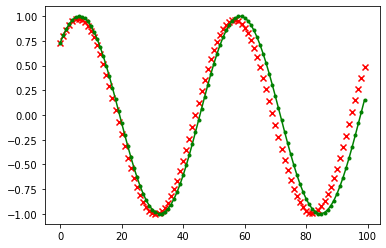

In [102]:
   
fig, ax = plt.subplots()
ax.plot(range(len(testy)), testy, marker='.', color='g')
ax.scatter(range(len(preds)), preds, marker='x', color='r')
fig.show()

In [25]:
def window_series(series, window_size, batch_size):
    series = tf.data.Dataset.from_tensor_slices(series)
    ds = series.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(10)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

window_size = 10
batch_size = 16
y_train = window_series(y, window_size, batch_size)

In [27]:
for i,j in y_train:
    print(i.shape, j.shape)
    break

(16, 10, 1) (16, 1)


In [29]:
model = Sequential([InputLayer(input_shape=(window_size, )),
                    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                    LSTM(16, return_sequences=False),
                    Dense(16),                    
                    Flatten(),
                    #Dropout(.1),
                    Dense(1)])
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 10, 1)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
flatten_4 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(y_train, epochs=50)

Epoch 1/50
31/31 [==============================] - 1s 3ms/step - loss: 0.3809 - mape: 118.8889
Epoch 2/50
31/31 [==============================] - 0s 3ms/step - loss: 0.1491 - mape: 181.7751
Epoch 3/50
31/31 [==============================] - 0s 3ms/step - loss: 0.1141 - mape: 158.3511
Epoch 4/50
31/31 [==============================] - 0s 3ms/step - loss: 0.0889 - mape: 143.3269
Epoch 5/50
31/31 [==============================] - 0s 3ms/step - loss: 0.0665 - mape: 124.9913
Epoch 6/50
31/31 [==============================] - 0s 3ms/step - loss: 0.0451 - mape: 102.7264
Epoch 7/50
31/31 [==============================] - 0s 3ms/step - loss: 0.0242 - mape: 73.5456
Epoch 8/50
31/31 [==============================] - 0s 3ms/step - loss: 0.0079 - mape: 38.5531
Epoch 9/50
31/31 [==============================] - 0s 3ms/step - loss: 0.0014 - mape: 11.9910
Epoch 10/50
31/31 [==============================] - 0s 3ms/step - loss: 5.5734e-04 - mape: 7.3666
Epoch 11/50
31/31 [=====================

In [31]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
y_train2 = TimeseriesGenerator(y, y, stride=1, length=10, batch_size=16)
for i,j in y_train2:
    print(i, '->', j)
    break

# model = Sequential([InputLayer(input_shape=(window_size, )),
#                     Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
#                     LSTM(16, return_sequences=False),
#                     Dense(16),                    
#                     Flatten(),
#                     #Dropout(.1),
#                     Dense(1)])
# model.compile(loss='mse', optimizer='adam', metrics=['mape'])
# model.summary()



model = Sequential([InputLayer(input_shape=(window_size, )),
                    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                    LSTM(16, return_sequences=False),
                    Dense(16),                    
                    #Flatten(),
                    #Dropout(.1),
                    Dense(1)])
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
model.fit(y_train2, epochs=90)

[[ 0.15425145  0.03462239 -0.08550663 -0.20440091 -0.32034356 -0.43166033
  -0.53674377 -0.63407644 -0.72225281 -0.79999959]
 [ 0.03462239 -0.08550663 -0.20440091 -0.32034356 -0.43166033 -0.53674377
  -0.63407644 -0.72225281 -0.79999959 -0.86619409]
 [-0.08550663 -0.20440091 -0.32034356 -0.43166033 -0.53674377 -0.63407644
  -0.72225281 -0.79999959 -0.86619409 -0.91988043]
 [-0.20440091 -0.32034356 -0.43166033 -0.53674377 -0.63407644 -0.72225281
  -0.79999959 -0.86619409 -0.91988043 -0.96028336]
 [-0.32034356 -0.43166033 -0.53674377 -0.63407644 -0.72225281 -0.79999959
  -0.86619409 -0.91988043 -0.96028336 -0.98681945]
 [-0.43166033 -0.53674377 -0.63407644 -0.72225281 -0.79999959 -0.86619409
  -0.91988043 -0.96028336 -0.98681945 -0.99910551]
 [-0.53674377 -0.63407644 -0.72225281 -0.79999959 -0.86619409 -0.91988043
  -0.96028336 -0.98681945 -0.99910551 -0.99696413]
 [-0.63407644 -0.72225281 -0.79999959 -0.86619409 -0.91988043 -0.96028336
  -0.98681945 -0.99910551 -0.99696413 -0.98042622]


31/31 [==============================] - 0s 3ms/step - loss: 3.6317e-05 - mape: 1.4008
Epoch 63/90
31/31 [==============================] - 0s 3ms/step - loss: 3.6733e-05 - mape: 1.4479
Epoch 64/90
31/31 [==============================] - 0s 3ms/step - loss: 2.8397e-05 - mape: 1.1489
Epoch 65/90
31/31 [==============================] - 0s 3ms/step - loss: 2.5040e-05 - mape: 1.0954
Epoch 66/90
31/31 [==============================] - 0s 3ms/step - loss: 2.3306e-05 - mape: 1.1011
Epoch 67/90
31/31 [==============================] - 0s 3ms/step - loss: 2.0310e-05 - mape: 1.0570
Epoch 68/90
31/31 [==============================] - 0s 3ms/step - loss: 1.8893e-05 - mape: 0.9603
Epoch 69/90
31/31 [==============================] - 0s 3ms/step - loss: 1.7290e-05 - mape: 0.9998
Epoch 70/90
31/31 [==============================] - 0s 3ms/step - loss: 1.5202e-05 - mape: 0.9000
Epoch 71/90
31/31 [==============================] - 0s 3ms/step - loss: 1.3692e-05 - mape: 0.7625
Epoch 72/90
31/31 [===

[ 0.15425145  0.03462239 -0.08550663 -0.20440091 -0.32034356 -0.43166033
 -0.53674377 -0.63407644 -0.72225281 -0.79999959]
-0.866194088230713


C:\Users\weiliu\AppData\Local\Temp\ipykernel_6536\3526750938.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


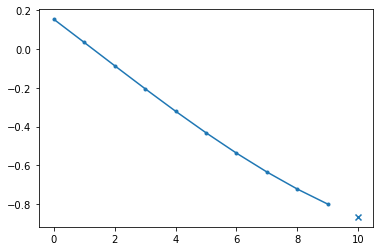

In [32]:
fig, ax = plt.subplots()
for i, j in y_train:
    print(i.numpy()[0])
    print(j.numpy()[0])    
    ax.plot(range(len(i.numpy()[0])), i.numpy()[0], marker='.')
    ax.scatter([len(i.numpy()[0])], j.numpy()[0], marker='x')
    fig.show()
    break

In [33]:
steps = 100
predicts = list(y[:window_size])
for i in range(steps):
    current_window = predicts[-window_size:]
    pred = model.predict(np.expand_dims(current_window, 0))[0][0]
    predicts.append(pred)


(0.0, 120.0)

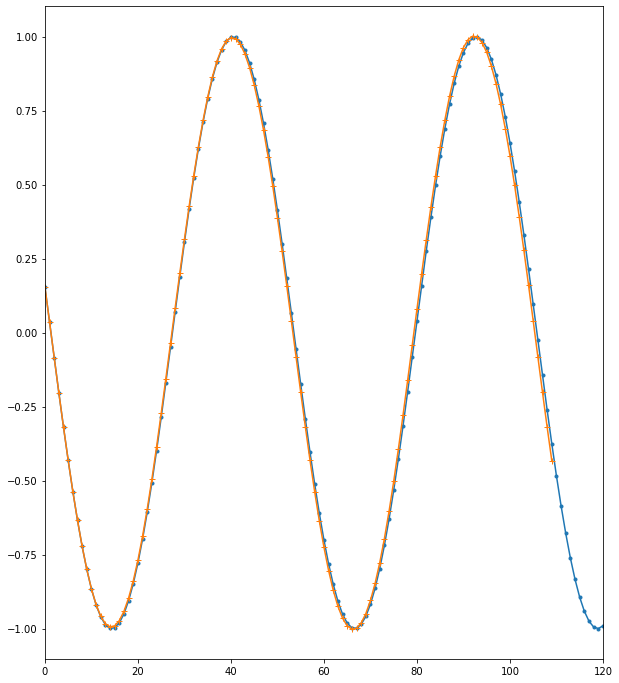

In [34]:
fig, ax = plt.subplots(figsize=(10, 12))
plt.plot(range(len(y)), y, marker='.')
plt.plot(range(len(predicts)), predicts, marker='+')
ax.set_xlim(0, 120)


In [35]:
y_train2[0][0].shape

(16, 10)

In [36]:
len(y)

500

In [40]:
def predict_into_future(model, first_batch_seed, predict_future_steps, time_steps, n_features):
    """
    model: model
    first_batch_seed: in general, this is the last batch of the training dataset
    predict_future_steps: how many steps we are predicting to the future, in general, this should be len(test_data)
    time_steps: How many LSTM cells
    n_features: Input shape for a single LSTM cell
    for example: LSTM(16, input_shape=(time_steps, n_features))
    
    """
    import numpy as np
    current_batch = first_batch_seed.reshape((1, time_steps, n_features))  # LSTM(16, input_shape=(time_steps, n_features))
    predictions = []
    print(f'we will predict {predict_future_steps} steps into future')
    for i in range(predict_future_steps):
        #print(f"step: {i}")
        current_pred = model.predict(current_batch)[0]
        predictions.append(current_pred)
        current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    return predictions
    

test_predition2 = predict_into_future(model, 
                                      first_batch_seed=y[:window_size],
                                      predict_future_steps=100, 
                                      time_steps=window_size, 
                                      n_features=1)

we will predict 100 steps into future


In [41]:
test_predition2

[array([-0.8660573], dtype=float32),
 array([-0.9190086], dtype=float32),
 array([-0.9583215], dtype=float32),
 array([-0.98346955], dtype=float32),
 array([-0.9942094], dtype=float32),
 array([-0.9905583], dtype=float32),
 array([-0.97273654], dtype=float32),
 array([-0.9411074], dtype=float32),
 array([-0.8961294], dtype=float32),
 array([-0.8383427], dtype=float32),
 array([-0.768393], dtype=float32),
 array([-0.68708026], dtype=float32),
 array([-0.5954075], dtype=float32),
 array([-0.49466708], dtype=float32),
 array([-0.38644177], dtype=float32),
 array([-0.27255335], dtype=float32),
 array([-0.15495153], dtype=float32),
 array([-0.03557232], dtype=float32),
 array([0.08378074], dtype=float32),
 array([0.20149459], dtype=float32),
 array([0.3161312], dtype=float32),
 array([0.42635912], dtype=float32),
 array([0.5308685], dtype=float32),
 array([0.62830555], dtype=float32),
 array([0.71724564], dtype=float32),
 array([0.79621756], dtype=float32),
 array([0.8637729], dtype=float32

(0.0, 120.0)

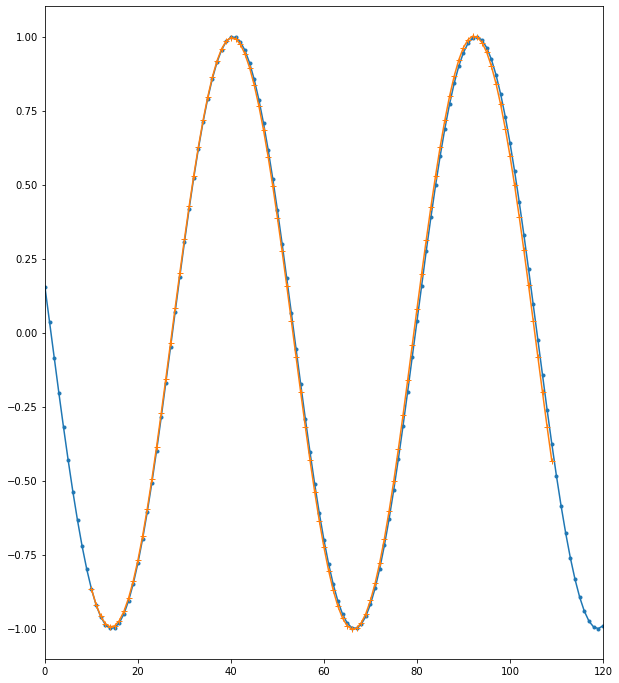

In [45]:
fig, ax = plt.subplots(figsize=(10, 12))
plt.plot(range(len(y)), y, marker='.')
plt.plot(range(window_size, len(test_predition2)+window_size), test_predition2, marker='+')
ax.set_xlim(0, 120)
